In [ ]:
pip install scipy

In [ ]:
pip install pymoo

In [3]:
import scipy.io
import numpy as np
# Load the .mat file
# (No. of features) : 7128
mat_contents = scipy.io.loadmat('CNS_Split.mat')
dataset_name = "CNS,60"
# Display the contents
#print(mat_contents)
data = mat_contents
X_train =data['datatrain']
X_test = data['datatest']
Y_test=data['labelstest'].ravel()
Y_train = data['labelstrain'].ravel()
print(X_train.shape)
print(X_test.shape)
#print(data)

(41, 7128)
(19, 7128)


In [ ]:
import scipy.io
import numpy as np
# Load the .mat file
# (No. of features) : 24481
mat_contents = scipy.io.loadmat('Breast_Split.mat')
dataset_name = "Breast,97"
# Display the contents
#print(mat_contents)
data = mat_contents
X_train =data['datatrain']
X_test = data['datatest']
Y_test=data['labelstest'].ravel()
Y_train = data['labelstrain'].ravel()
print(X_train.shape)
print(X_test.shape)
#print(data)

In [ ]:
import scipy.io
import numpy as np
# Load the .mat file
# (No. of features) : 9182
mat_contents = scipy.io.loadmat('CARCINOM_Split.mat')
dataset_name = "CARCINOM,174"
# Display the contents
#print(mat_contents)
data = mat_contents
X_train =data['datatrain']
X_test = data['datatest']
Y_test=data['labelstest'].ravel()
Y_train = data['labelstrain'].ravel()
print(X_train.shape)
print(X_test.shape)
#print(data)

In [ ]:
import scipy.io
import numpy as np
# Load the .mat file
# (No. of features) : 2308
mat_contents = scipy.io.loadmat('SRBCT_Split.mat')
dataset_name = "SRBCT_Split,83"
# Display the contents
#print(mat_contents)
data = mat_contents
X_train =data['datatrain']
X_test = data['datatest']
Y_test=data['labelstest'].ravel()
Y_train = data['labelstrain'].ravel()
print(X_train.shape)
print(X_test.shape)
#print(data)

In [ ]:
import scipy.io
import numpy as np
# Load the .mat file
# (No. of features) : 12533
mat_contents = scipy.io.loadmat('11Tumor_Split.mat')
dataset_name = "11Tumor,174"
# Display the contents
#print(mat_contents)
data = mat_contents
X_train =data['datatrain']
X_test = data['datatest']
Y_test=data['labelstest'].ravel()
Y_train = data['labelstrain'].ravel()
print(Y_test.shape)
#print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('leukemia.mat')
dataset_name = "leukemia,72"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('CLL_SUB_111.mat')
dataset_name = "CLL_SUB_111,111"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('nci9.mat')
dataset_name = "nci9,60"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('TOX_171.mat')
dataset_name = "TOX_171,171"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('lung_discrete.mat')
dataset_name = "lung_discrete,325"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('colon.mat')
dataset_name = "colon,62"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('Prostate.mat')
dataset_name = "Prostate,102"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('ALLAML.mat')
dataset_name = "ALLAML,72"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('lymphoma.mat')
dataset_name = "lymphoma,96"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('GLIOMA.mat')
dataset_name = "Glioma,50"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('lung.mat')
dataset_name = "Lung,203"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('GLI_85.mat')
dataset_name = "GLI,85"
# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

In [ ]:
# import scipy.io

# # # Load the .mat file
# mat_contents = scipy.io.loadmat('leukemia.mat')

# # Display the contents
# #print(mat_contents)
# data = mat_contents
# X = data['X']
# Y=data['Y'].ravel()
# print("X =",X)
# print("Y =",Y)
# print(X.shape[1])
# print(data)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.termination import get_termination
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from pymoo.indicators.hv import HV
import pandas as pd
from pymoo.core.sampling import Sampling
import random
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import os
from sklearn.model_selection import KFold
import pickle

In [ ]:
X.shape, Y.shape

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42,stratify=Y)

In [5]:
data_test_saved = {
    'X_test': X_test,
    'Y_test': Y_test
}
with open(f'data_test{dataset_name}.pkl', 'wb') as f:
    pickle.dump(data_test_saved, f)

In [ ]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

In [ ]:
# Check the distribution of classes
def class_distribution(X):
    unique, counts = np.unique(X, return_counts=True)
    return dict(zip(unique, counts))

# Original dataset distribution
original_dist = class_distribution(X)
print("Original dataset distribution:", original_dist)

# Training set distribution
train_dist = class_distribution(X_train)
print("Training set distribution:", train_dist)

# Test set distribution
test_dist = class_distribution(X_test)
print("Test set distribution:", test_dist)

In [ ]:
# Check the distribution of classes
def class_distribution(Y):
    unique, counts = np.unique(Y, return_counts=True)
    return dict(zip(unique, counts))

# Original dataset distribution
original_dist = class_distribution(Y)
print("Original dataset distribution:", original_dist)

# Training set distribution
train_dist = class_distribution(Y_train)
print("Training set distribution:", train_dist)

# Test set distribution
test_dist = class_distribution(Y_test)
print("Test set distribution:", test_dist)

In [ ]:
print(X_train)
print(Y_train)

In [ ]:
class MyProblem(Problem):
    def __init__(self):
        super().__init__(n_var=2000, # decision variables
                         n_obj=2,  # two objective functions
                        n_ieq_constr=1 
                        )

    def _classification_error(self, bitstring):
        featureNames = []
        for i in range(len(bitstring)):
            if bitstring[i] == 1:
                featureNames.append(i)
  
        if len(featureNames) == 0:
            return 1
        else:
            trainx = X_train[:,featureNames]
            trainy = Y_train
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(trainx, trainy)
            Y_pred = knn.predict(trainx)
            ac = accuracy_score(trainy, Y_pred)
            return 1 - ac

    def _features_number(self, bitstring):
        return sum(bitstring)

    def _constrain(self,bitstring):
        return 1 - sum(bitstring)
    
    def _evaluate(self, x, out, *args, **kwargs):
        f1 = [self._features_number(x[i]) for i in range(len(x))]
        f2 = [self._classification_error(x[i]) for i in range(len(x))]
        g1 = [self._constrain(x[i]) for i in range(0, len(x))]
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])

In [6]:
class generate_population(Sampling):
        def __init__(self):
            super().__init__()
            
        def _do(self, problem, n_samples, **kwargs):
            total_features = 7128
            population_size = 100
            population = []
            for _ in range(population_size):
                n = random.randint(1, total_features) 
                individual = [0] * total_features
                selected_indices = random.sample(range(total_features), n)
                for idx in selected_indices :
                    individual[idx] = 1
                population.append(individual)
            return population

In [7]:
#xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.3, random_state=42)
xtrain = X_train
xtest = X_test
ytrain = Y_train
ytest = Y_test
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(xtrain, ytrain)
ypred = knn.predict(xtrain)
ac = accuracy_score(ytrain, ypred)
print(ac)
print("Classification error on training sets using all features: " + str(1 - ac))
ypred = knn.predict(xtest)
ac = accuracy_score(ytest, ypred)
print(ac)
print("Classification error on testing sets using all features: " + str(1 - ac))

print("###################################################################################")

0.7317073170731707
Classification error on training sets using all features: 0.2682926829268293
0.7368421052631579
Classification error on testing sets using all features: 0.26315789473684215
###################################################################################


In [ ]:
#problem = FeatureSelectionProblem(X,Y)


In [ ]:
problem = MyProblem()

In [ ]:
algorithm = NSGA2(pop_size=100,
                  sampling=generate_population(),
                  crossover=UniformCrossover(prob=0.9),
                  mutation=BitflipMutation(prob=0.01),
                  eliminate_duplicates=True)

In [ ]:
termination = get_termination("n_gen", 40)

In [ ]:
res = minimize(problem,
               algorithm,
               termination,
               seed=42,
               save_history=True,
               verbose=True)

i_f = res.history[0].opt.get("F")
i_pop = res.history[0].pop
f = res.F
pop = res.pop
pop_test = res.pop
solutions = res.X

In [ ]:
print("the intial pareto front is plotted as: ")
plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the initial pareto front")
plt.show()
print("the final pareto front is plotted as: ")
plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the final pareto front")
plt.show()

In [ ]:
# Get the minimum error from the optimization result
min_error_train = np.min(f[:, 1])

# Print the minimum error with increased decimals
print("Minimum error on training dataset: {:.10f}".format(min_error_train))

In [ ]:
# print(res.F[:,1])
# print(res.F[:,0])
# print(pop.get("F")[:,0])
# print(pop.get("F")[:,1])

In [ ]:
def evaluate_on_test(X_test, Y_test, solution):
    feature_indices = [i for i in range(len(solution)) if solution[i] == 1]
    if len(feature_indices) == 0:
        return [X.shape[1], 1.0]
    else:
        X_test_selected = X_test[:, feature_indices]
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train[:, feature_indices], Y_train)
        Y_pred = knn.predict(X_test_selected)
        error_rate = 1 - accuracy_score(Y_test, Y_pred)
        return [len(feature_indices), error_rate]

In [ ]:
# Evaluate each solution on the test data
print(len(pop_test.get("X")))
print(len(res.X))
print(pop_test.get("X"))
Solutions_test = np.array([evaluate_on_test(X_test, Y_test, solution) for solution in res.X])

# Perform non-dominated sorting
nds = NonDominatedSorting().do(Solutions_test)

# Extract the Pareto front solutions
pareto_front_indices = nds[0]
pareto_front_objectives_test = Solutions_test[pareto_front_indices]


# print(f"Total number of solutions: {len(Solutions_test)}")
# print(f"Number of Pareto front solutions: {len(pareto_front_indices)}")
# print("Some solutions from the last generation:", Solutions_test[:5])
# print("Pareto front solutions:", pareto_front_objectives)


# Plot the Pareto front graph
print("The final Pareto front is plotted as:")
plt.scatter(Solutions_test[:, 0], Solutions_test[:, 1], edgecolor="blue", facecolor="none", label="Solutions")
plt.scatter(pareto_front_objectives_test[:, 0], pareto_front_objectives_test[:, 1], marker='*', edgecolor="red", facecolor="none", label="Optimal Pareto front")
plt.xlabel('Number of Features')
plt.ylabel('Test Error')
plt.legend()
plt.title("Visualization of the Final Pareto Front after NDS")
plt.show()

In [ ]:
# Plot the Pareto front for test data
import matplotlib.pyplot as plt

plt.scatter(f_test[:, 0], f_test[:, 1], edgecolor="blue", facecolor="none", label="Test Data Pareto Front")
plt.scatter(optimal_solution[0], optimal_solution[1], marker='*', color='red', s=100, label="Optimal Solution")
plt.xlabel('Number of Features')
plt.ylabel('Error Rate')
plt.legend()
plt.title("Pareto Front on Test Data")
plt.show()

In [ ]:
ref_point = np.array([1, 1])
ind = HV(ref_point=ref_point)
scaler = MinMaxScaler()
f_train = scaler.fit_transform(f)
hv_train = ind(f_train)
print("HV of the best pareto front train:" + str(round(hv_train, 2)))

In [ ]:
ref_point = np.array([1, 1])
ind = HV(ref_point=ref_point)
scaler = MinMaxScaler()
f_t = scaler.fit_transform(Solutions_test)
hv_test = ind(f_t)
print("HV of the best pareto front test:" + str(round(hv_test, 2)))

In [ ]:
# Extracting and plotting the Pareto Front from all generations
pareto_fronts = [gen.opt.get("F") for gen in res.history]

for i, pareto in enumerate(pareto_fronts):
    plt.scatter(pareto[:, 0], pareto[:, 1])

plt.xlabel('Number of Features')
plt.ylabel('Training Error Rate')
plt.title('Pareto Front Evolution')
plt.legend()
plt.show()



In [ ]:
# Get the minimum error from the optimization result
min_error_test = np.min(Solutions_test[:,1])

# Print the minimum error
print("Minimum error on testing dataset:", min_error_test)

In [ ]:
# Get the minimum error from the optimization result
min_error_train = np.min(res.F[:, 1])

# Find the row(s) where the error is minimized
min_error_indices = np.where(res.F[:, 1] == min_error_train)[0]

# Get the corresponding solutions with minimum error
solutions_with_min_error = res.X[min_error_indices]

# Get the number of features for the solutions with minimum error
num_features_with_min_error_train = [np.count_nonzero(solution) for solution in solutions_with_min_error]

# Print the number of features with minimum error
print("Number of features with minimum error on train:", num_features_with_min_error_train)

In [ ]:
num_features_with_min_error_test = np.min(Solutions_test[:,0])
print("Number of features with minimum error on test data:",num_features_with_min_error_test)

In [ ]:
from prettytable import PrettyTable

# Create a PrettyTable instance
table = PrettyTable()

# Set the column alignment
table.align = "l"

# Define the column names
table.field_names = ["Info abt. Db", "H.V.(Train)", "H.V.(Test)", 
                     "Min. Error(Train)", "Min. Err(Test)", "Feat.w Min.Err(Trn.)", 
                     "Feat.w Min.Err(Tst)"]

# Populate the table with data
dataset_info = "Lukemia,72,7070"
dataset_name = "Lukemia"
hv_training = "{:.2f}".format(hv_train)
hv_testing = "{:.2f}".format(hv_test)
min_error_training = "{:.5f}".format(min_error_train)
min_error_testing = "{:.5f}".format(min_error_test)
min_error_features_training = num_features_with_min_error_train[0]
min_error_features_testing = num_features_with_min_error_test


# Add data to the table row
table.add_row([dataset_info, hv_training, hv_testing, min_error_training, min_error_testing,
               min_error_features_training, min_error_features_testing])


# Print the table
print(table)


# (TRAIN + Validation ) For Voting




In [8]:
class MyProblem_Split(Problem):
    def __init__(self, X_train1,Y_train1):
        super().__init__(n_var=7128,  # decision variables
                         n_obj=2,    # two objective functions
                         n_ieq_constr=1  # one inequality constraint
                        )
        self.X_train1 = X_train1
        self.Y_train1 = Y_train1

    def _classification_error(self, bitstring):
        featureNames = [i for i in range(len(bitstring)) if bitstring[i] == 1]
        
        if len(featureNames) == 0:
            return 1
        else:
            trainx = self.X_train1[:, featureNames]
            trainy = self.Y_train1
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(trainx, trainy)
            Y_pred = knn.predict(trainx)
            ac = accuracy_score(trainy, Y_pred)
            return 1 - ac

    def _features_number(self, bitstring):
        return sum(bitstring)

    def _constrain(self, bitstring):
        return 1 - sum(bitstring)

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = [self._features_number(x[i]) for i in range(len(x))]
        f2 = [self._classification_error(x[i]) for i in range(len(x))]
        g1 = [self._constrain(x[i]) for i in range(0, len(x))]
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])
        
# def evaluate_on_valid_data(X, Y, solution):
#     feature_indices = [i for i in range(len(solution)) if solution[i] == 1]
#     if len(feature_indices) == 0:
#         return [X_test.shape[1], 1.0]
#     else:
#         X_selected = X_train[:, feature_indices]
#         testx = X[:,feature_indices]
#         knn = KNeighborsClassifier(n_neighbors=5)
#         knn.fit(X_selected, Y_train)
#         ypred = knn.predict(testx)
#         ac = accuracy_score(ytest, ypred)
#         error_rate = 1 - ac
#         return [len(feature_indices), error_rate]
def evaluate_on_valid_data(X_train, Y_train, X_valid, Y_valid, solution):
    feature_indices = [i for i in range(len(solution)) if solution[i] == 1]
    if len(feature_indices) == 0:
        return [X_valid.shape[1], 1.0,np.zeros_like(solution)]
    else:
        X_selected = X_train[:, feature_indices]
        X_valid_selected = X_valid[:, feature_indices]
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_selected, Y_train)
        y_pred = knn.predict(X_valid_selected)
        ac = accuracy_score(Y_valid, y_pred)
        error_rate = 1 - ac
        return [len(feature_indices), error_rate,solution]

Run 1:
(36, 7128) (5, 7128) (36,) (5,)
the intial pareto front is plotted as: 


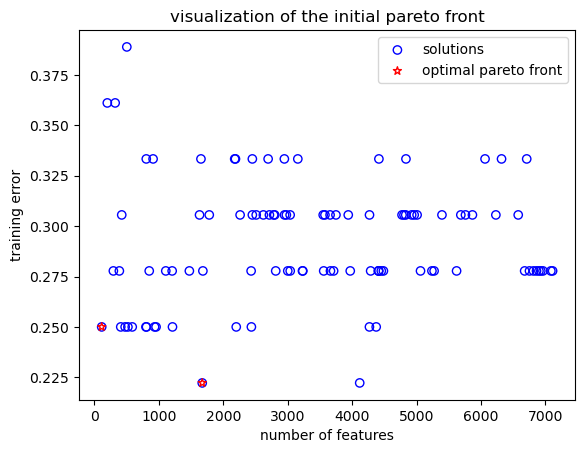

the final pareto front is plotted as: 


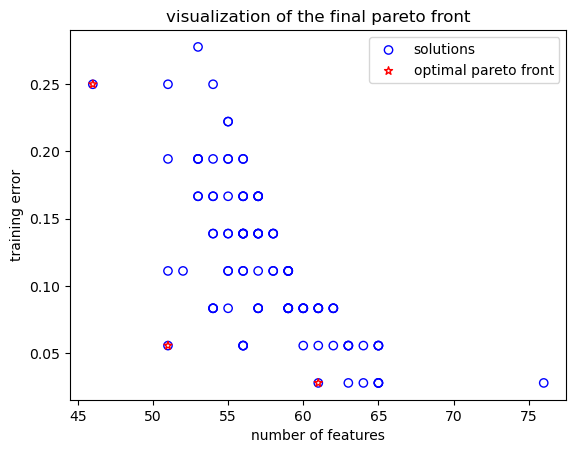

0.02777777777777779
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


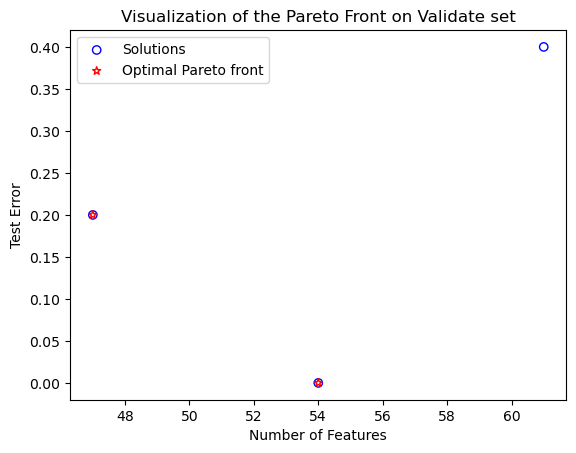

Non-dominated binary vector with 54 features:
54.0
[4, 65, 389, 417, 423, 426, 676, 744, 825, 901, 951, 986, 1083, 1218, 1249, 1488, 1635, 1895, 1937, 2023, 2066, 2205, 2243, 2298, 2337, 2371, 2510, 2576, 2653, 2802, 2978, 3115, 3490, 3882, 3925, 3933, 4024, 4115, 4173, 4347, 4843, 4968, 5188, 5197, 5274, 5408, 5743, 6178, 6233, 6281, 6798, 6965, 7003, 7080]
0.6842105263157895
0.3157894736842105
Run 2:
(37, 7128) (4, 7128) (37,) (4,)
the intial pareto front is plotted as: 


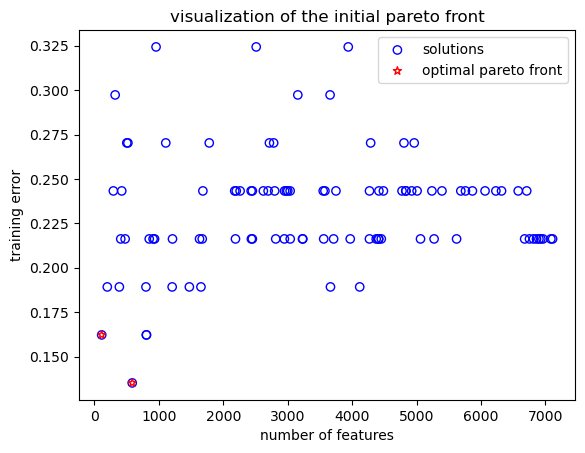

the final pareto front is plotted as: 


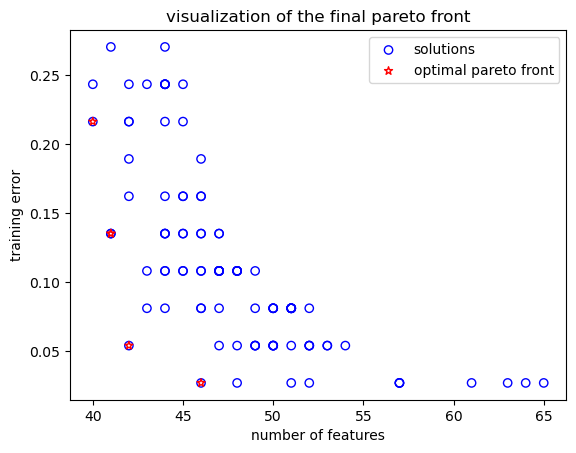

0.02740240240240238
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


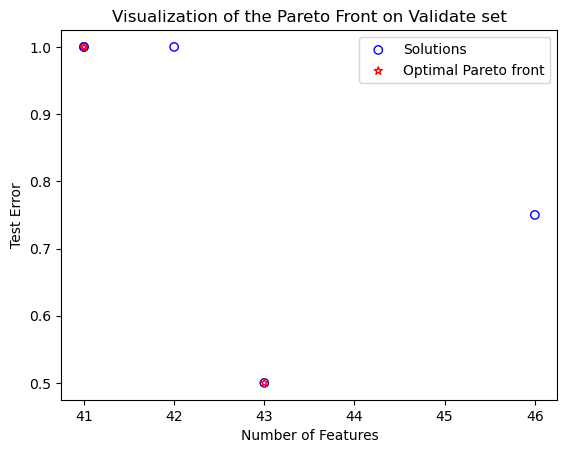

Non-dominated binary vector with 43 features:
48.5
[764, 825, 844, 1010, 1249, 1484, 1488, 1514, 1530, 1545, 1574, 1635, 1736, 2137, 2295, 2298, 2510, 2576, 2620, 2634, 2753, 3336, 3492, 3513, 3529, 3925, 3980, 4300, 4968, 5171, 5197, 5274, 5457, 5606, 5743, 5938, 5983, 6041, 6233, 6281, 6286, 6722, 7079]
0.631578947368421
0.34210526315789475
Run 3:
(37, 7128) (4, 7128) (37,) (4,)
the intial pareto front is plotted as: 


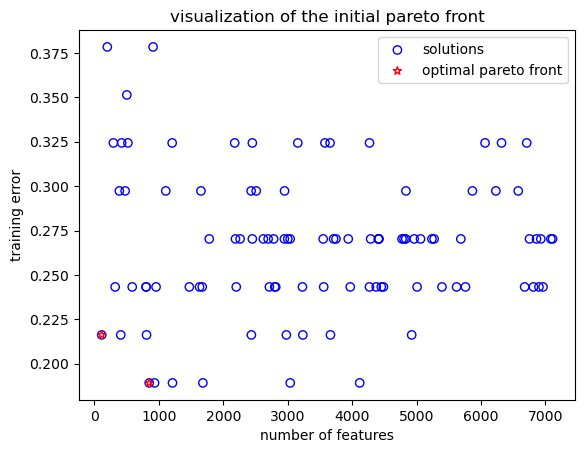

the final pareto front is plotted as: 


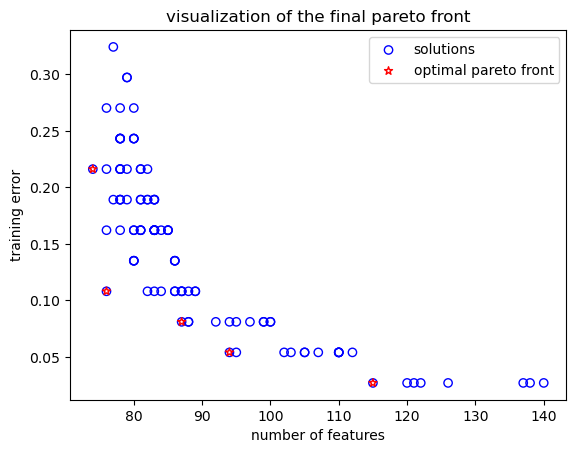

0.027277277277277245
[array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


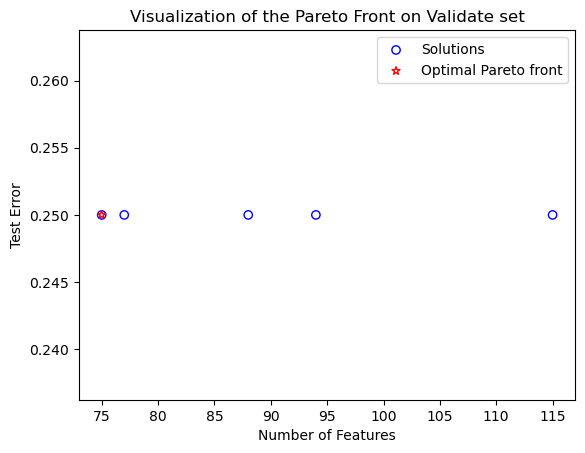

Non-dominated binary vector with 75 features:
57.333333333333336
[4, 314, 334, 389, 426, 427, 502, 676, 825, 844, 878, 1197, 1400, 1484, 1488, 1545, 1574, 1625, 1736, 1895, 1937, 2023, 2029, 2158, 2205, 2298, 2311, 2337, 2492, 2510, 2620, 2634, 2802, 2875, 3115, 3287, 3336, 3492, 3498, 3513, 3867, 3882, 3925, 3980, 4176, 4188, 4458, 4482, 4843, 5006, 5050, 5059, 5152, 5188, 5197, 5274, 5315, 5410, 5504, 5556, 5606, 5735, 5742, 5829, 5942, 5974, 5983, 6041, 6233, 6281, 6412, 6635, 6798, 7003, 7079]
0.631578947368421
0.3508771929824562
Run 4:
(37, 7128) (4, 7128) (37,) (4,)
the intial pareto front is plotted as: 


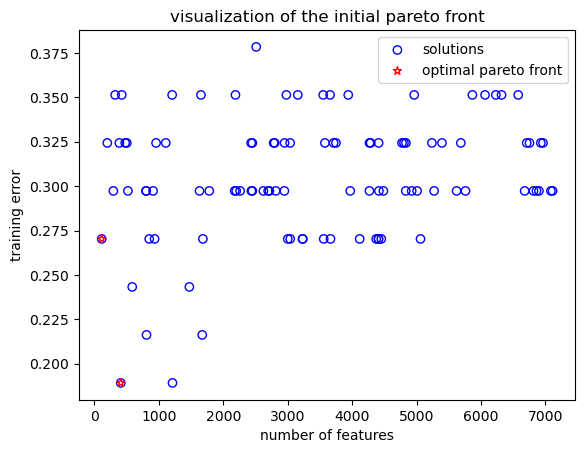

the final pareto front is plotted as: 


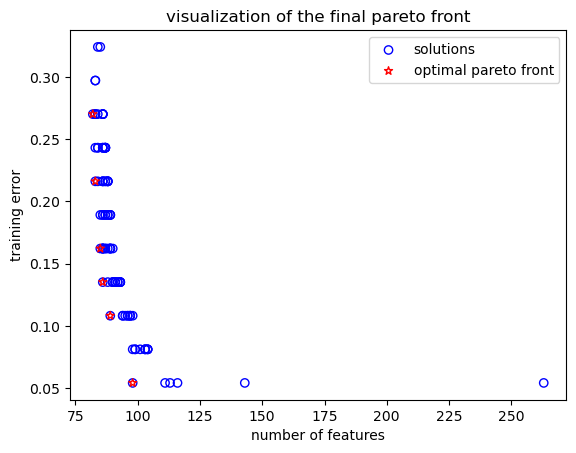

0.03397147147147145
[array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


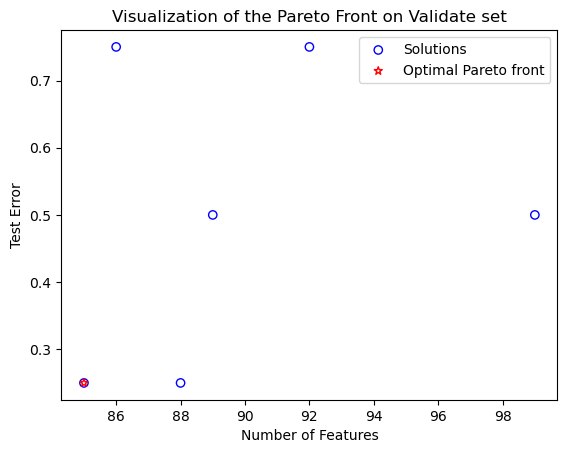

Non-dominated binary vector with 85 features:
64.25
[4, 65, 144, 263, 314, 334, 389, 417, 423, 427, 502, 676, 744, 825, 844, 942, 986, 1083, 1197, 1218, 1484, 1488, 1514, 1530, 1635, 1736, 1879, 1937, 2018, 2023, 2066, 2094, 2158, 2205, 2243, 2298, 2311, 2337, 2371, 2492, 2510, 2634, 2753, 2802, 2978, 3115, 3287, 3336, 3378, 3424, 3558, 3867, 3882, 3925, 3933, 3980, 4024, 4115, 4176, 4188, 4300, 4843, 4891, 4968, 5050, 5059, 5152, 5197, 5274, 5410, 5458, 5556, 5735, 5742, 5743, 5787, 5829, 6010, 6041, 6101, 6286, 6412, 6798, 7003, 7079]
0.6842105263157895
0.3421052631578948
Run 5:
(37, 7128) (4, 7128) (37,) (4,)
the intial pareto front is plotted as: 


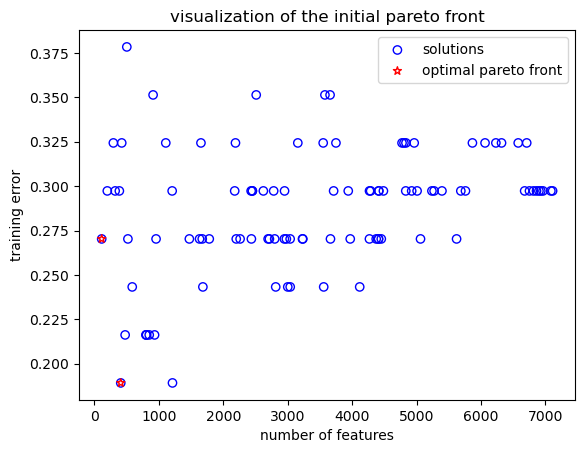

the final pareto front is plotted as: 


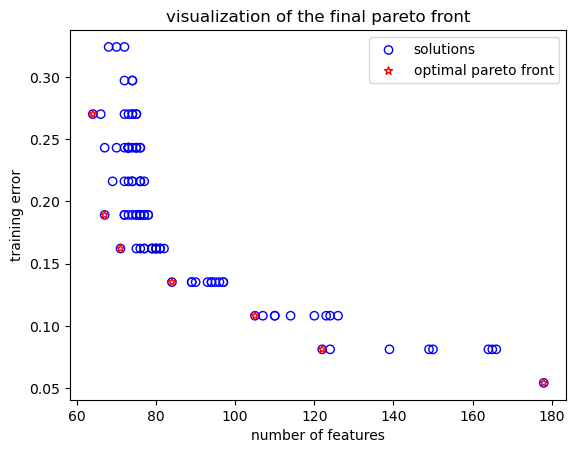

0.03798798798798797
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


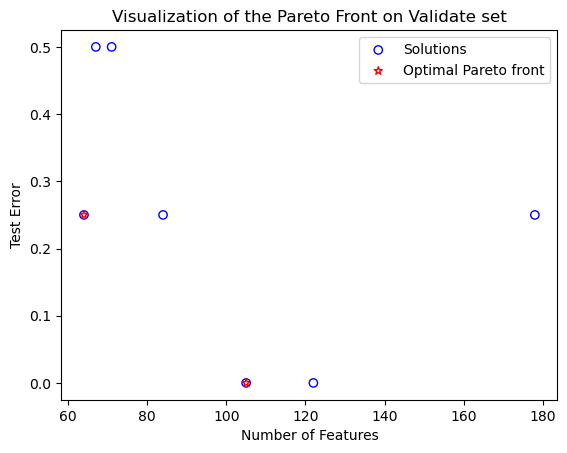

Non-dominated binary vector with 105 features:
72.4
[4, 41, 82, 228, 314, 417, 423, 456, 501, 502, 607, 744, 825, 942, 986, 1083, 1117, 1218, 1249, 1407, 1484, 1545, 1574, 1682, 1689, 1736, 1816, 1844, 1879, 1895, 1937, 2015, 2026, 2066, 2205, 2243, 2298, 2303, 2311, 2337, 2371, 2492, 2510, 2620, 2631, 2634, 2753, 2802, 2955, 3115, 3134, 3287, 3336, 3490, 3492, 3498, 3513, 3519, 3529, 3558, 3867, 3882, 3925, 4013, 4024, 4115, 4176, 4265, 4300, 4466, 4512, 4559, 4843, 4891, 4968, 5006, 5152, 5157, 5188, 5197, 5410, 5606, 5636, 5742, 5743, 5787, 5829, 5850, 5974, 6101, 6125, 6233, 6286, 6344, 6412, 6473, 6510, 6635, 6650, 6722, 6798, 6958, 6966, 7003, 7080]
0.7368421052631579
0.3263157894736842
Run 6:
(37, 7128) (4, 7128) (37,) (4,)
the intial pareto front is plotted as: 


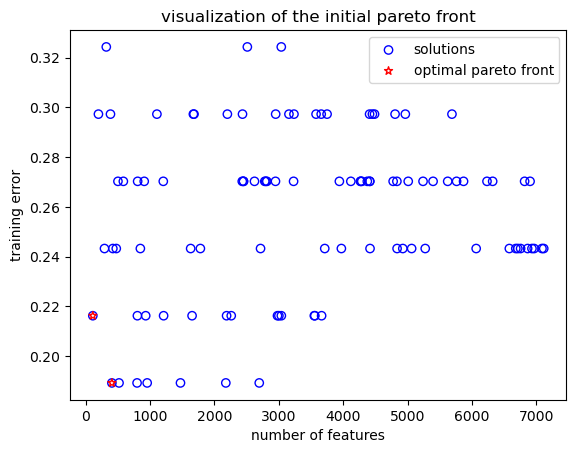

the final pareto front is plotted as: 


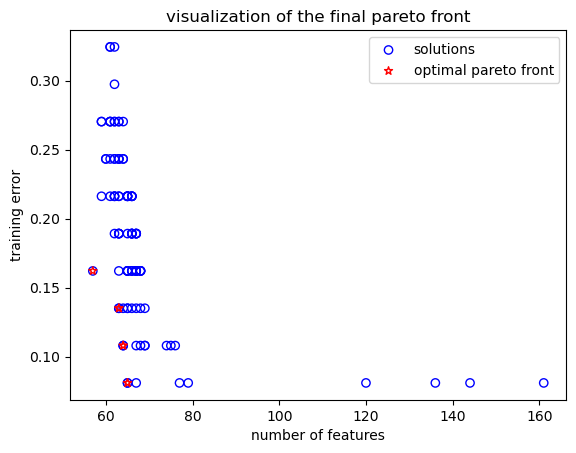

0.045170170170170144
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


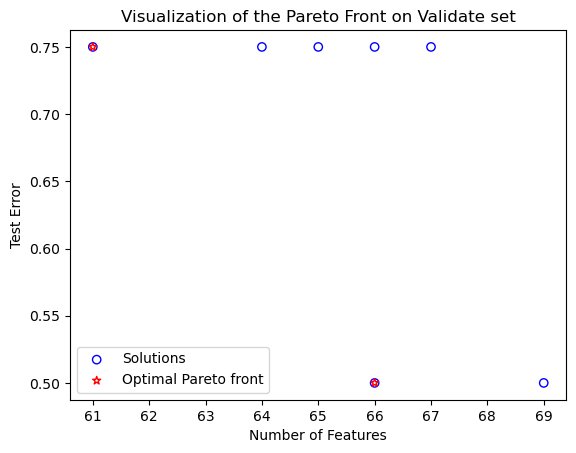

Non-dominated binary vector with 66 features:
71.33333333333333
[4, 314, 383, 417, 427, 901, 942, 986, 1083, 1249, 1312, 1484, 1514, 1545, 1625, 1736, 2023, 2026, 2043, 2066, 2171, 2205, 2295, 2337, 2371, 2413, 2492, 2620, 2634, 2753, 2802, 2978, 3287, 3424, 3492, 3498, 3558, 3802, 3867, 3925, 3980, 4115, 4147, 4300, 5006, 5050, 5152, 5188, 5197, 5274, 5458, 5606, 5633, 5735, 5742, 5743, 5787, 5974, 5983, 6041, 6281, 6722, 6798, 7003, 7079, 7090]
0.6842105263157895
0.324561403508772
Run 7:
(37, 7128) (4, 7128) (37,) (4,)
the intial pareto front is plotted as: 


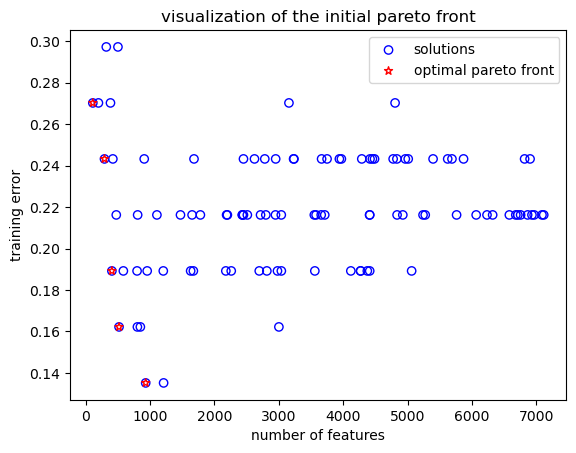

the final pareto front is plotted as: 


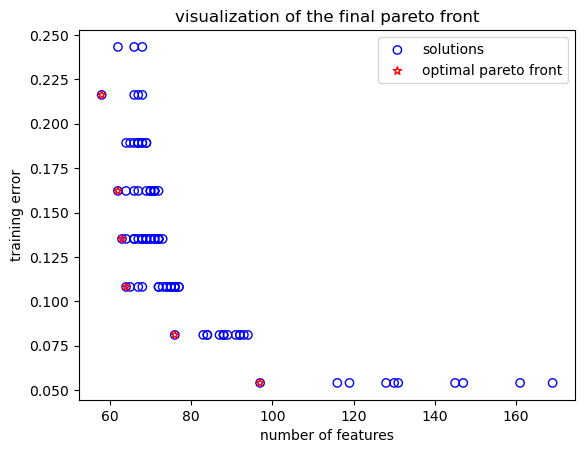

0.04643929643929642
[array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


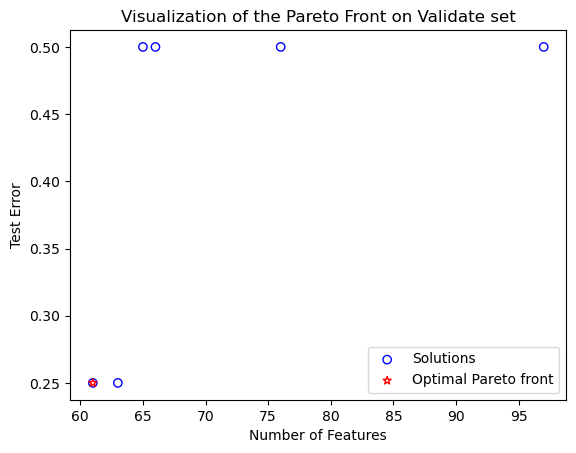

Non-dominated binary vector with 61 features:
69.85714285714286
[144, 314, 423, 427, 744, 942, 1083, 1197, 1249, 1484, 1488, 1497, 1514, 1530, 1545, 1625, 1736, 1879, 1895, 1937, 2008, 2023, 2026, 2043, 2066, 2298, 2303, 2311, 2383, 2492, 2620, 2634, 2753, 2802, 2978, 3115, 3336, 3490, 3498, 3519, 3558, 3882, 4176, 4188, 4300, 4460, 4876, 5006, 5152, 5188, 5274, 5410, 5735, 5743, 5787, 5974, 6233, 6281, 6493, 6798, 7003]
0.5789473684210527
0.33834586466165417
Run 8:
(37, 7128) (4, 7128) (37,) (4,)
the intial pareto front is plotted as: 


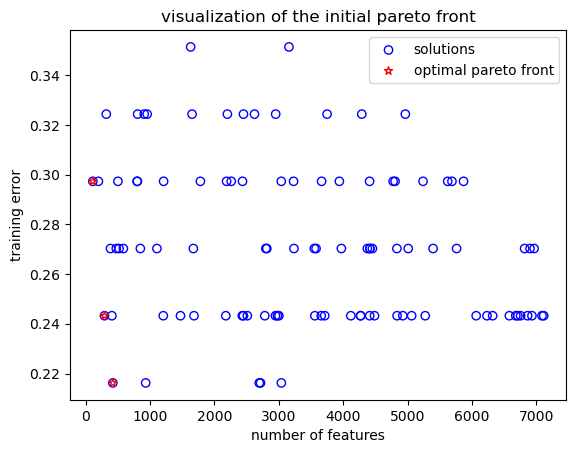

the final pareto front is plotted as: 


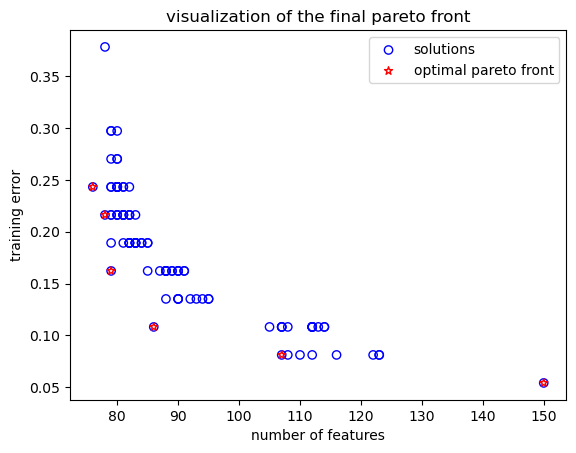

0.047391141141141124
[array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


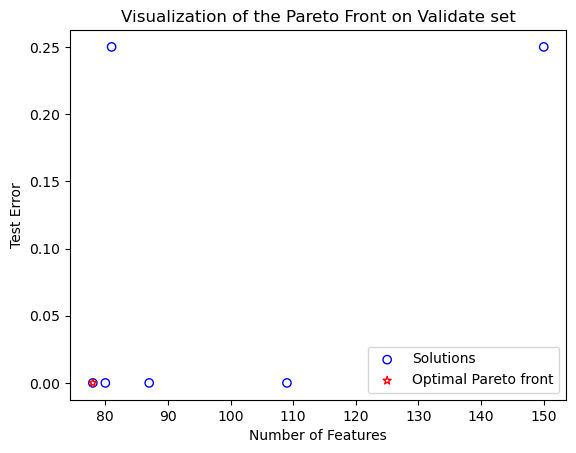

Non-dominated binary vector with 78 features:
70.875
[4, 65, 144, 334, 417, 423, 427, 676, 744, 844, 986, 1083, 1197, 1484, 1488, 1514, 1530, 1545, 1611, 1625, 1736, 1816, 1879, 1937, 2023, 2026, 2043, 2066, 2158, 2295, 2298, 2303, 2311, 2337, 2371, 2492, 2510, 2620, 2802, 2970, 3115, 3287, 3336, 3490, 3492, 3513, 3515, 3579, 3882, 3925, 3980, 4024, 4115, 4176, 4300, 4381, 4843, 4968, 5006, 5013, 5050, 5274, 5410, 5556, 5735, 5742, 5743, 5768, 5787, 5829, 5912, 5974, 5983, 6286, 6635, 6716, 7003, 7080]
0.5789473684210527
0.3486842105263158
Run 9:
(37, 7128) (4, 7128) (37,) (4,)
the intial pareto front is plotted as: 


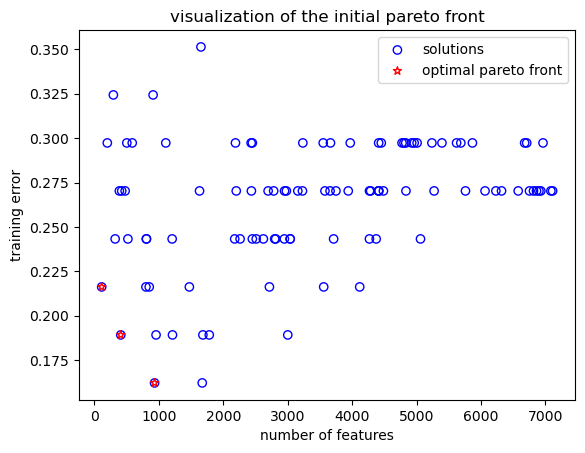

the final pareto front is plotted as: 


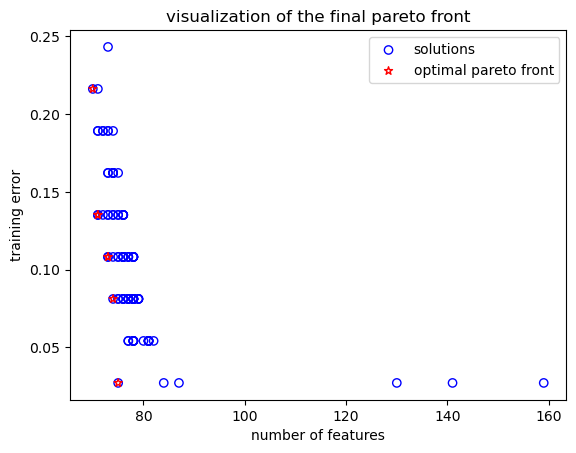

0.045128461795128444
[array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


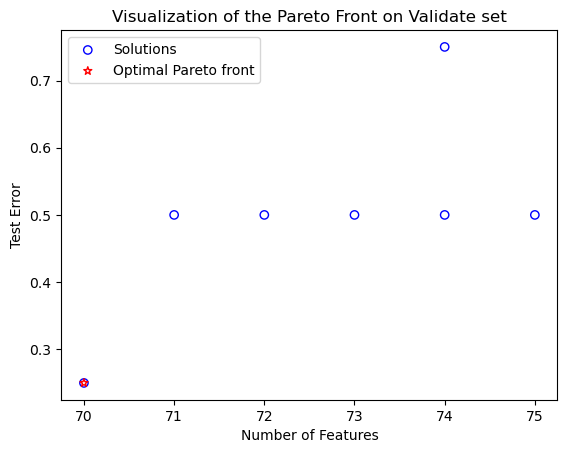

Non-dominated binary vector with 70 features:
70.77777777777777
[4, 65, 112, 144, 314, 334, 389, 417, 426, 427, 676, 744, 901, 942, 1004, 1083, 1197, 1218, 1249, 1484, 1488, 1545, 1625, 1736, 1793, 1879, 1895, 1937, 2029, 2066, 2205, 2243, 2298, 2371, 2492, 2510, 2620, 2802, 2875, 3115, 3336, 3490, 3498, 3558, 3867, 3882, 3925, 3980, 4024, 4115, 4176, 4300, 4843, 4968, 5006, 5050, 5059, 5152, 5188, 5197, 5458, 5606, 5742, 5974, 6041, 6281, 6412, 7003, 7079, 7080]
0.6842105263157895
0.3450292397660819
Run 10:
(37, 7128) (4, 7128) (37,) (4,)
the intial pareto front is plotted as: 


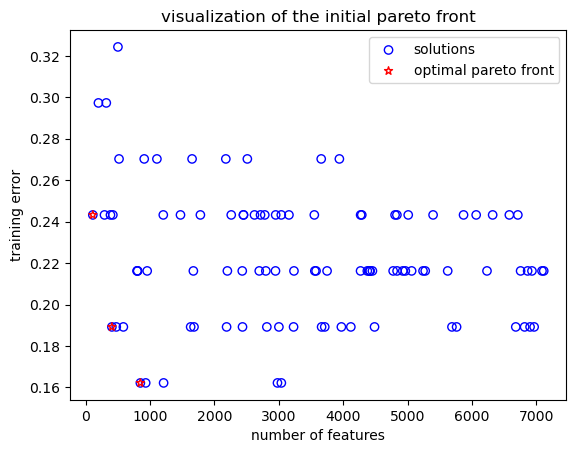

the final pareto front is plotted as: 


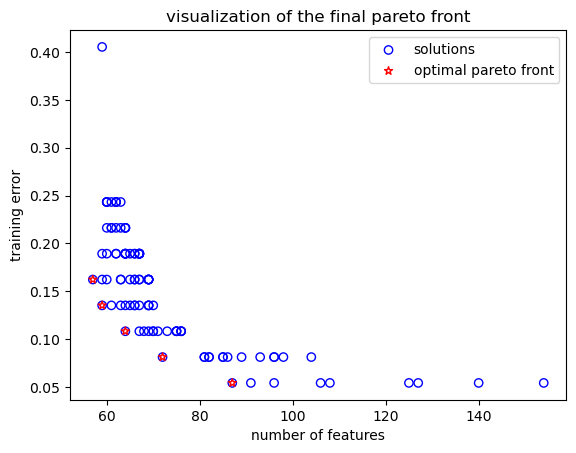

0.046021021021021
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
The final Pareto front is plotted as:


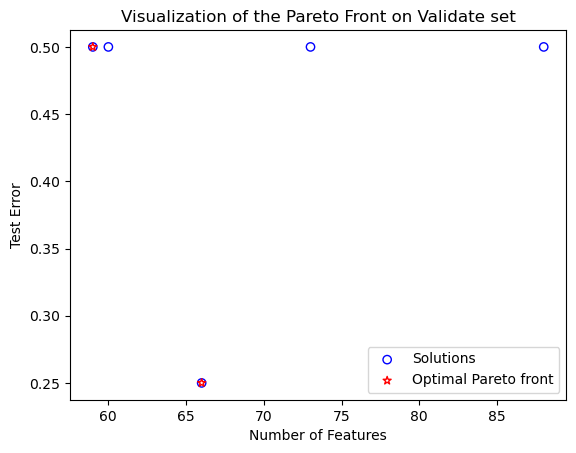

Non-dominated binary vector with 66 features:
70.3
[4, 41, 65, 127, 142, 343, 389, 744, 844, 901, 942, 986, 1083, 1249, 1341, 1484, 1488, 1514, 1530, 1625, 1736, 1895, 1937, 2029, 2043, 2158, 2165, 2205, 2295, 2298, 2311, 2321, 2875, 2964, 2978, 3300, 3307, 3490, 3492, 3498, 3513, 3515, 3882, 3925, 4148, 4176, 4698, 4943, 4968, 5006, 5059, 5152, 5197, 5410, 5556, 5606, 5633, 5735, 5829, 5890, 5974, 6041, 6101, 6233, 6398, 6635]
0.5263157894736842
0.3578947368421053


In [9]:
# Directory to save the solutions
save_dir = 'pareto_solutions'
os.makedirs(save_dir, exist_ok=True)

kfold = KFold(n_splits=10, shuffle=True, random_state=None)
fold_iterator = kfold.split(X_train, Y_train)
err_avg=[]
avg_min_train_error= []
min_err_validation=[]
k=[]
# Loop for 10 runs
for run in range(1, 10+1):
#for run in range(0, 1):
    print(f"Run {run}:")
    train_indices, test_indices = next(fold_iterator)
    X_train1, X_valid1 = X_train[train_indices], X_train[test_indices]
    Y_train1, Y_valid1 = Y_train[train_indices], Y_train[test_indices]
    print(X_train1.shape,X_valid1.shape,Y_train1.shape, Y_valid1.shape)
    #print(X_train.shape, Y_train.shape)
    #X_train1, X_valid1, Y_train1, Y_valid1 = train_test_split(X_train, Y_train, test_size=0.3, random_state=None)
    problem_split = MyProblem_Split(X_train1,Y_train1)
    algorithm = NSGA2(pop_size=100,
                  sampling=generate_population(),
                  crossover=UniformCrossover(prob=0.9),
                  mutation=BitflipMutation(prob=0.01),
                  eliminate_duplicates=True)
    termination = get_termination("n_gen", 50)
    res = minimize(problem_split,
                   algorithm,
                   termination,
                   seed=42,
                   save_history=True,
                   verbose=False)

    i_f = res.history[0].opt.get("F")
    i_pop = res.history[0].pop
    f = res.F
    pop = res.pop
    pop_valid = res.pop
    solutions = res.X
    print("the intial pareto front is plotted as: ")
    plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
    plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
    plt.xlabel('number of features')
    plt.ylabel('training error')
    plt.legend()
    plt.title("visualization of the initial pareto front")
    plt.show()
    print("the final pareto front is plotted as: ")
    plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
    plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
    plt.xlabel('number of features')
    plt.ylabel('training error')
    plt.legend()
    plt.title("visualization of the final pareto front")
    plt.show()

    avg_min_train_error.append(np.min(f[:,1]))
    avg_err_train=np.mean(avg_min_train_error)
    print(avg_err_train)
    # Evaluate each solution on the validation data 
    results = [evaluate_on_valid_data(X_train1, Y_train1, X_valid1, Y_valid1, solution) for solution in res.X]    
    
    
    # Separate the main results and binary vectors
    Solutions_valid = np.array([result[:2] for result in results])
    binary_vectors = [result[2] for result in results]
    
    
    # Perform non-dominated sorting
    nds = NonDominatedSorting().do(Solutions_valid)
    
    
    # Extract the Pareto front solutions
    pareto_front_indices = nds[0]
    pareto_front_objectives = Solutions_valid[pareto_front_indices]
    
    
    non_dominated_binary_vectors = [binary_vectors[i] for i in pareto_front_indices]
    
    print(non_dominated_binary_vectors)
    
    
    
    # Save the Pareto front binary vectors to a file
    file_path = os.path.join(save_dir, f'pareto_front_solutions_run_{run}_{dataset_name}.npy')
    np.save(file_path, non_dominated_binary_vectors)



    # Plot the Pareto front graph
    print("The final Pareto front is plotted as:")
    plt.scatter(Solutions_valid[:, 0], Solutions_valid[:, 1], edgecolor="blue", facecolor="none", label="Solutions")
    plt.scatter(pareto_front_objectives[:, 0], pareto_front_objectives[:, 1], marker='*', edgecolor="red", facecolor="none", label="Optimal Pareto front")
    plt.xlabel('Number of Features')
    plt.ylabel('Test Error')
    plt.legend()
    plt.title("Visualization of the Pareto Front on Validate set")
    plt.show()
    
    
    min_err_validation.append(np.min(pareto_front_objectives[:, 1]))
    avg_min_error_valid=np.mean(min_err_validation)
    
    with open(f'data_test{dataset_name}.pkl', 'rb') as f:
        data_test_open = pickle.load(f)
    X_test_open = data_test_open['X_test']
    Y_test_open = data_test_open['Y_test']
    
    
    for idx, vector in enumerate(non_dominated_binary_vectors):
        low_error=np.min(Solutions_valid[:,1])
        feature_no=np.where(low_error==Solutions_valid[:,1])[0]
        feature_index = [i for i in range(len(vector)) if vector[i] == 1]
        for i,f in Solutions_valid[feature_no]:
            if(i==len(feature_index)):
                print(f"Non-dominated binary vector with {len(feature_index)} features:")
                k.append(len(feature_index))
                avg_feat_evry_run = np.mean(k)
                print(np.mean(k))
                print(feature_index)
                selected_features = feature_index
                X_selected = X_train[:, selected_features]
                testx = X_test_open[:,selected_features]
                knn = KNeighborsClassifier(n_neighbors=5)
                knn.fit(X_selected, Y_train)
                ypred = knn.predict(testx)
                ac = accuracy_score(Y_test_open, ypred)
                err_test = 1-ac
                err_avg.append(err_test)
                print(ac)
                #print(acc_avg)
                test_err = np.mean(err_avg)
                print(np.mean(err_avg))
    

    
   
    

In [ ]:
#     free=np.min(pareto_front_objectives[:,1])
#     # Find the row(s) where the error is minimized
#     min_error_indices = np.where(free==pareto_front_objectives[:,1])[0]
#     print(pareto_front_objectives[min_error_indices])
#     #print(pareto_front_solutions[min_error_indices].flatten())
    
    
#     l=0;
#     for i in pareto_front_solutions[min_error_indices]:
#         for j in i:
#             if(j==1):
#                 l+=j;     
#     print(l)
        #print(i)
    #print(pareto_front_solutions[min_error_indices])
    #print(min_error_indices)

In [ ]:
# acc_avg=[]
# for i in range(0,10):
#     selected_features = pareto_front_solutions[min_error_indices].flatten()
#     X_selected = X_train[:, selected_features]
#     testx = X_test[:,selected_features]
#     #print(X_selected)
#     knn = KNeighborsClassifier(n_neighbors=5)
#     knn.fit(X_selected, Y_train)
#     ypred = knn.predict(testx)
#     ac = accuracy_score(ytest, ypred)
#     acc_avg.append(ac)
#     print(ac)
# print(acc_avg)
# print(np.mean(acc_avg))

In [10]:
# Load the Pareto front binary vectors from files and perform voting
save_dir = 'pareto_solutions'
os.makedirs(save_dir, exist_ok=True)
feature_frequency = np.zeros(7128, dtype=int)

for run in range(1, 10 + 1):
    # Load the Pareto front binary vectors from the file
    file_path = os.path.join(save_dir, f'pareto_front_solutions_run_{run}_{dataset_name}.npy')
    pareto_front_solutions = np.load(file_path)
    #print(len(pareto_front_solutions))
    for solution in pareto_front_solutions:
            feature_frequency += solution
    

# Print the frequency of each feature being selected
j=0;
m=0;

# Create pairs of (feature, frequency)
feature_frequency_pairs = list(enumerate(feature_frequency))

# Sort the pairs based on frequency in descending order
sorted_feature_frequency_pairs = sorted(feature_frequency_pairs, key=lambda x: x[1], reverse=True)

#Get the top 100 pairs
top_100_feature_frequency_pairs = sorted_feature_frequency_pairs[:100]
frequencies_data = []
freq_frequencies=[]
print("Feature selection frequency across 10 runs:")
for i, (feature, frequency) in enumerate(top_100_feature_frequency_pairs):
    if(frequency>0):
        print(f"Feature {feature}: {frequency} times")
        frequencies_data.append(f'Feature {feature}: {frequency} times')
        freq_frequencies.append(f'Feature {feature},{frequency} times')
        m += 1
frequencies_data = np.array(frequencies_data, dtype=object)        
file_path = os.path.join(save_dir, f'Freq_{dataset_name}_.npy')
np.save(file_path,frequencies_data)
print("No. of Features:",m);


    

Feature selection frequency across 10 runs:
Feature 1484: 14 times
Feature 3925: 14 times
Feature 4: 12 times
Feature 1736: 12 times
Feature 2298: 12 times
Feature 2371: 12 times
Feature 5197: 12 times
Feature 1083: 11 times
Feature 1249: 11 times
Feature 1488: 11 times
Feature 1545: 11 times
Feature 3882: 11 times
Feature 5274: 11 times
Feature 5606: 11 times
Feature 5743: 11 times
Feature 6041: 11 times
Feature 7003: 11 times
Feature 744: 10 times
Feature 942: 10 times
Feature 986: 10 times
Feature 1895: 10 times
Feature 2205: 10 times
Feature 2620: 10 times
Feature 2802: 10 times
Feature 3492: 10 times
Feature 4300: 10 times
Feature 4968: 10 times
Feature 5006: 10 times
Feature 5152: 10 times
Feature 5735: 10 times
Feature 6798: 10 times
Feature 427: 9 times
Feature 844: 9 times
Feature 1625: 9 times
Feature 1937: 9 times
Feature 2066: 9 times
Feature 2492: 9 times
Feature 2510: 9 times
Feature 2634: 9 times
Feature 2753: 9 times
Feature 3115: 9 times
Feature 3336: 9 times
Feature 4

In [11]:
# Convert frequencies_data to a DataFrame
df = pd.DataFrame(freq_frequencies, columns=[f"Freq_features_{dataset_name}"])

# Save the DataFrame to an Excel file
file_path_excel = os.path.join(save_dir, f'Frequent_freq_{dataset_name}_.xlsx')
df.to_excel(file_path_excel, index=False)

In [12]:
    total_feat= 7128
    select_feat = []
    feat_after_voting=[]
    test_error_after_voting = []
    with open(f'data_test{dataset_name}.pkl', 'rb') as f:
        data_test_open = pickle.load(f)
    X_test_vot = data_test_open['X_test']
    Y_test_vot = data_test_open['Y_test']
    

    #print(top_100_feature_frequency_pairs);
select_feat = [] 
acc_app= []
    for j,(feature,frequency) in enumerate(top_100_feature_frequency_pairs):
        if(j<m):
            select_feat.append(feature)
            print(len(select_feat))
            print(select_feat)
            feat_after_voting.append(len(select_feat))
            X_selected = X_train[:, select_feat]
            testx = X_test_vot[:,select_feat]
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(X_selected, Y_train)
            ypred = knn.predict(testx)
            acu = accuracy_score(Y_test_vot, ypred)
            err_voting = 1-acu
            test_error_after_voting.append(err_voting)
            print(acu)
            print(f"Error:{err_voting}")
            acc_app.append(acu)
            max_acc = np.max(acc_app)
            print(max_acc)




1
[1484]
0.47368421052631576
Error:0.5263157894736843
0.47368421052631576
2
[1484, 3925]
0.3684210526315789
Error:0.631578947368421
0.47368421052631576
3
[1484, 3925, 4]
0.5263157894736842
Error:0.4736842105263158
0.5263157894736842
4
[1484, 3925, 4, 1736]
0.42105263157894735
Error:0.5789473684210527
0.5263157894736842
5
[1484, 3925, 4, 1736, 2298]
0.5263157894736842
Error:0.4736842105263158
0.5263157894736842
6
[1484, 3925, 4, 1736, 2298, 2371]
0.5263157894736842
Error:0.4736842105263158
0.5263157894736842
7
[1484, 3925, 4, 1736, 2298, 2371, 5197]
0.47368421052631576
Error:0.5263157894736843
0.5263157894736842
8
[1484, 3925, 4, 1736, 2298, 2371, 5197, 1083]
0.5263157894736842
Error:0.4736842105263158
0.5263157894736842
9
[1484, 3925, 4, 1736, 2298, 2371, 5197, 1083, 1249]
0.5263157894736842
Error:0.4736842105263158
0.5263157894736842
10
[1484, 3925, 4, 1736, 2298, 2371, 5197, 1083, 1249, 1488]
0.5263157894736842
Error:0.4736842105263158
0.5263157894736842
11
[1484, 3925, 4, 1736, 2298

0.5789473684210527
Error:0.42105263157894735
0.7368421052631579
67
[1484, 3925, 4, 1736, 2298, 2371, 5197, 1083, 1249, 1488, 1545, 3882, 5274, 5606, 5743, 6041, 7003, 744, 942, 986, 1895, 2205, 2620, 2802, 3492, 4300, 4968, 5006, 5152, 5735, 6798, 427, 844, 1625, 1937, 2066, 2492, 2510, 2634, 2753, 3115, 3336, 4115, 4176, 5742, 5974, 314, 417, 1514, 1530, 2023, 2158, 2337, 3490, 3498, 3513, 3980, 5188, 5410, 5787, 6233, 6281, 7079, 65, 389, 423, 825]
0.631578947368421
Error:0.368421052631579
0.7368421052631579
68
[1484, 3925, 4, 1736, 2298, 2371, 5197, 1083, 1249, 1488, 1545, 3882, 5274, 5606, 5743, 6041, 7003, 744, 942, 986, 1895, 2205, 2620, 2802, 3492, 4300, 4968, 5006, 5152, 5735, 6798, 427, 844, 1625, 1937, 2066, 2492, 2510, 2634, 2753, 3115, 3336, 4115, 4176, 5742, 5974, 314, 417, 1514, 1530, 2023, 2158, 2337, 3490, 3498, 3513, 3980, 5188, 5410, 5787, 6233, 6281, 7079, 65, 389, 423, 825, 901]
0.631578947368421
Error:0.368421052631579
0.7368421052631579
69
[1484, 3925, 4, 1736, 22

0.6842105263157895
Error:0.3157894736842105
0.7368421052631579
96
[1484, 3925, 4, 1736, 2298, 2371, 5197, 1083, 1249, 1488, 1545, 3882, 5274, 5606, 5743, 6041, 7003, 744, 942, 986, 1895, 2205, 2620, 2802, 3492, 4300, 4968, 5006, 5152, 5735, 6798, 427, 844, 1625, 1937, 2066, 2492, 2510, 2634, 2753, 3115, 3336, 4115, 4176, 5742, 5974, 314, 417, 1514, 1530, 2023, 2158, 2337, 3490, 3498, 3513, 3980, 5188, 5410, 5787, 6233, 6281, 7079, 65, 389, 423, 825, 901, 1218, 2295, 2311, 2978, 3287, 3558, 3867, 4024, 4843, 5050, 5829, 5983, 6286, 676, 1574, 1635, 1879, 2243, 6635, 144, 334, 1197, 2026, 2043, 5059, 5556, 6412, 7080]
0.6842105263157895
Error:0.3157894736842105
0.7368421052631579
97
[1484, 3925, 4, 1736, 2298, 2371, 5197, 1083, 1249, 1488, 1545, 3882, 5274, 5606, 5743, 6041, 7003, 744, 942, 986, 1895, 2205, 2620, 2802, 3492, 4300, 4968, 5006, 5152, 5735, 6798, 427, 844, 1625, 1937, 2066, 2492, 2510, 2634, 2753, 3115, 3336, 4115, 4176, 5742, 5974, 314, 417, 1514, 1530, 2023, 2158, 2337, 3

In [13]:
for i,frequency in enumerate(feature_frequency):
    if(frequency>0):
        print(f"Feature {i}: {frequency} times")
        j += 1
print("No. of Features:",j);

Feature 4: 12 times
Feature 41: 2 times
Feature 65: 7 times
Feature 82: 1 times
Feature 112: 1 times
Feature 127: 1 times
Feature 142: 1 times
Feature 144: 5 times
Feature 228: 1 times
Feature 263: 1 times
Feature 314: 8 times
Feature 334: 5 times
Feature 343: 2 times
Feature 383: 2 times
Feature 389: 7 times
Feature 417: 8 times
Feature 423: 7 times
Feature 426: 4 times
Feature 427: 9 times
Feature 456: 2 times
Feature 474: 1 times
Feature 501: 1 times
Feature 502: 4 times
Feature 510: 1 times
Feature 607: 1 times
Feature 676: 6 times
Feature 744: 10 times
Feature 764: 1 times
Feature 825: 7 times
Feature 844: 9 times
Feature 878: 1 times
Feature 901: 7 times
Feature 942: 10 times
Feature 951: 1 times
Feature 986: 10 times
Feature 1004: 1 times
Feature 1010: 2 times
Feature 1083: 11 times
Feature 1117: 1 times
Feature 1197: 5 times
Feature 1218: 7 times
Feature 1249: 11 times
Feature 1312: 3 times
Feature 1341: 2 times
Feature 1400: 1 times
Feature 1407: 1 times
Feature 1484: 14 times

In [14]:
# Create a dictionary where keys are column names and values are the variables
data = {
    'Dataset': dataset_name,
    '#features':total_feat ,
    'Avg. of Min train error': avg_err_train,
    'Avg. of Min validation error':avg_min_error_valid,
    'Avg. of test error for every run':test_err,
    '#features for test':avg_feat_evry_run,
    'Test error after voting': test_error_after_voting,
    '#features for test after voting':feat_after_voting
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Specify the name of the Excel file
excel_file = f'output_{dataset_name}.xlsx'

# Write the DataFrame to an Excel file
df.to_excel(excel_file, index=False)

print(f'Data successfully written to {excel_file}')

Data successfully written to output_CNS,60.xlsx


In [ ]:
    #dataset_name = "lukemia"
    file_path = os.path.join(save_dir, f'Freq_{dataset_name}_.npy')
    frequencies_data = np.load(file_path, allow_pickle=True)
        # Display the loaded data
    print(frequencies_data)
    

In [ ]:
df = pd.DataFrame(frequencies_data)

# Define the Excel file path
excel_file_path = os.path.join(save_dir, f'Freq_{dataset_name}.xlsx')

# Save the DataFrame to an Excel file
df.to_excel(excel_file_path, index=False)

print(f'Data has been saved to {excel_file_path}')

In [ ]:
X_train1.shape, X_valid1.shape, Y_train1.shape, Y_valid1.shape

In [ ]:
 class MyProblem_Split(Problem):
    def __init__(self):
        super().__init__(n_var=7070, # decision variables
                         n_obj=2,  # two objective functions
                        n_ieq_constr=1 
                        )

    def _classification_error(self, bitstring):
        featureNames = []
        for i in range(len(bitstring)):
            if bitstring[i] == 1:
                featureNames.append(i)
  
        if len(featureNames) == 0:
            return 1
        else:
            trainx = X_train1[:,featureNames]
            trainy = Y_train1
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(trainx, trainy)
            Y_pred = knn.predict(trainx)
            ac = accuracy_score(trainy, Y_pred)
            return 1 - ac

    def _features_number(self, bitstring):
        return sum(bitstring)

    def _constrain(self,bitstring):
        return 1 - sum(bitstring)
    
    def _evaluate(self, x, out, *args, **kwargs):
        f1 = [self._features_number(x[i]) for i in range(len(x))]
        f2 = [self._classification_error(x[i]) for i in range(len(x))]
        g1 = [self._constrain(x[i]) for i in range(0, len(x))]
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])

In [ ]:
problem_split = MyProblem_Split()

In [ ]:
algorithm = NSGA2(pop_size=100,
                  sampling=generate_population(),
                  crossover=UniformCrossover(prob=0.9),
                  mutation=BitflipMutation(prob=0.01),
                  eliminate_duplicates=True)

In [ ]:
termination = get_termination("n_gen", 30)

In [ ]:
res = minimize(problem_split,
               algorithm,
               termination,
               seed=42,
               save_history=True,
               verbose=True)

i_f = res.history[0].opt.get("F")
i_pop = res.history[0].pop
f = res.F
pop = res.pop
pop_valid = res.pop
solutions = res.X

In [ ]:
print("the intial pareto front is plotted as: ")
plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the initial pareto front")
plt.show()
print("the final pareto front is plotted as: ")
plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the final pareto front")
plt.show()

In [ ]:
def evaluate_on_valid_data(X, Y, solution):
    feature_indices = [i for i in range(len(solution)) if solution[i] == 1]
    if len(feature_indices) == 0:
        return [X_test.shape[1], 1.0]
    else:
        X_test_selected = X[:, feature_indices]
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train1[:, feature_indices], Y_train1)
        Y_pred = knn.predict(X_test_selected)
        binary_vector = (Y_pred == 1).astype(int)
        error_rate = 1 - accuracy_score(Y, Y_pred)
        return [len(feature_indices), error_rate]

In [ ]:
# Evaluate each solution on the test data
Solutions_valid = np.array([evaluate_on_valid_data(X_valid1, Y_valid1, solution) for solution in pop_valid.get("X")])

# Perform non-dominated sorting
nds = NonDominatedSorting().do(Solutions_valid)

# Extract the Pareto front solutions
pareto_front_indices = nds[0]
pareto_front_objectives = Solutions_valid[pareto_front_indices]

# Plot the Pareto front graph
print("The final Pareto front is plotted as:")
plt.scatter(Solutions_valid[:, 0], Solutions_valid[:, 1], edgecolor="blue", facecolor="none", label="Solutions")
plt.scatter(pareto_front_objectives[:, 0], pareto_front_objectives[:, 1], marker='*', edgecolor="red", facecolor="none", label="Optimal Pareto front")
plt.xlabel('Number of Features')
plt.ylabel('Test Error')
plt.legend()
plt.title("Visualization of the Final Pareto Front")
plt.show()

In [ ]:
print(pareto_front_objectives[:,0])
print(pareto_front_objectives[:,1])

In [ ]:
# Retrieve the binary vectors of the Pareto front solutions
pareto_front_solutions = pop_valid.get("X")[pareto_front_indices]

# Print the Pareto front binary vectors
print("Binary vectors of the Pareto front solutions:")
for i, solution in enumerate(pareto_front_solutions):
    print(f"Solution {i + 1}: {solution}")